# Data Connection


1. Unstructured data

- Google Docs
- Threads from communication platforms such as Slack or Microsoft Teams
- Web pages
- Internal documentation (PDF)
- Code repositories on GitHub.

2. Structured data

- Data housed within SQL, NoSQL, or Graph databases.


To query your unstructured data,

- a process of loading, transforming, embedding, and subsequently storing it within a vector database is necessary.
- A vector database is a specialized type of database designed to efficiently store and query data in the form of vectors, which represent complex data like text or images in a format suitable for machine learning and similarity search.

As for structured data, given its already indexed and stored state,
you can utilize a LangChain agent to conduct an intermediate query on your database.


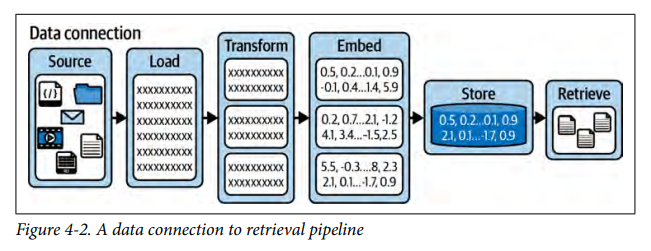


1. Document loaders
   These facilitate uploading informational resources, or documents, from a diverse
   range of sources such as Word documents, PDF files, text files, or even web
   pages.

2. Document transformers
   These tools allow the segmentation of documents, conversion into a Q&A layout,
   elimination of superfluous documents, and much more.

3. Text embedding models
   These can transform unstructured text into a sequence of floating-point numbers
   used for similarity search by vector stores.

4. Vector databases (vector stores)
   These databases can save and execute searches over embedded data.

5. Retrievers
   These tools offer the capability to query and retrieve data


- append() adds a single element (even if that element is a list or another iterable).
- extend() adds multiple elements by unpacking the iterable and adding its contents to the list.


In [1]:
list1 = [1, 2, 3]

# Using append
list1.append([4, 5])
print(list1)  # Output: [1, 2, 3, [4, 5]]

# Using extend
list1 = [1, 2, 3]  # Reset list
list1.extend([4, 5])
print(list1)  # Output: [1, 2, 3, 4, 5]

[1, 2, 3, [4, 5]]
[1, 2, 3, 4, 5]


- glob.glob() is a method in Python's glob module that is used to find all the file paths that match a specified pattern. The glob module provides functionality to work with wildcard patterns, similar to how you would use them in Unix/Linux shells (e.g., \*.txt to match all text files).


In [2]:
import glob

# List all Python files in the current directory
python_files = glob.glob("*.ipynb")
print(python_files)

['05_Few_Shot_SavePrompt.ipynb', '01_ChatModel_Message_Invoke_Stream_Batch_Config.ipynb', '04_Function_Calling.ipynb', 'test.ipynb', '06_DocumentLoader_TextSplitter.ipynb', '03_Output_Parser.ipynb', '02_ChatPrompt_LCEL_Prompt.ipynb']


# Document Loaders


In [36]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader, CSVLoader
import glob
from langchain.text_splitter import CharacterTextSplitter

all_document = []

### PDF Document Loader


In [37]:
loader = PyPDFLoader("./data/principles_of_marketing_book.pdf")
pages = loader.load_and_split()
print(pages[0])

page_content='Principles of Mark eting' metadata={'source': './data/principles_of_marketing_book.pdf', 'page': 0}


In [38]:
for page in pages:
    page.metadata["desciption"] = "Principles of Marketing Book"

In [39]:
for page in pages[0:2]:
    print(page.metadata)

{'source': './data/principles_of_marketing_book.pdf', 'page': 0, 'desciption': 'Principles of Marketing Book'}
{'source': './data/principles_of_marketing_book.pdf', 'page': 1, 'desciption': 'Principles of Marketing Book'}


In [40]:
all_document.extend(pages)
# print(all_document)

### CSV Document Loader


In [41]:
csv_files = glob.glob("./data/*.csv")
print(csv_files)

['./data/2023 Marketing Performance Report.csv', './data/2022 Marketing Performance Report.csv', './data/2021 Marketing Performance Report.csv']


In [42]:
filter_csv_files = [f for f in csv_files if "Marketing" in f]
print(filter_csv_files)

['./data/2023 Marketing Performance Report.csv', './data/2022 Marketing Performance Report.csv', './data/2021 Marketing Performance Report.csv']


In [43]:
for file in filter_csv_files:
    loader = CSVLoader(file)
    data = loader.load()
    all_document.extend(data)

### Google Docs Document Loader


In [44]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200, chunk_overlap=0)

urls = [
    '''https://storage.googleapis.com/oreilly-content/NutriFusion%20Foods%20Marketing%20Plan%202022.docx''',
    '''https://storage.googleapis.com/oreilly-content/NutriFusion%20Foods%20Marketing%20Plan%202023.docx''',
]

for url in urls:
    loader = Docx2txtLoader(url.replace('\n', ''))
    pages = loader.load()
    chunks = text_splitter.split_documents(pages)

    for chunk in chunks:
        chunk.metadata['source'] = "NutriFusion Foods Marketing Plan - 2022/2023"
    all_document.extend(chunks)

In [47]:
# print(all_document)

# Text Splitting by Length and Token Size


In [50]:
from langchain_text_splitters import CharacterTextSplitter
text = """
Biology is a fascinating and diverse field of science that explores the
living world and its intricacies \n\n. It encompasses the study of life, its
origins, diversity, structure, function, and interactions at various levels
from molecules and cells to organisms and ecosystems \n\n. In this 1000-word
essay, we will delve into the core concepts of biology, its history, key
areas of study, and its significance in shaping our understanding of the
natural world. \n\n ...(truncated to save space)...
"""
# No chunk overlap:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=50, chunk_overlap=0, separator="\n",
)
texts = text_splitter.split_text(text)

print(f"Number of texts with no chunk overlap: {len(texts)}")

# Including a chunk overlap:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=50, chunk_overlap=48, separator="\n",
)
texts = text_splitter.split_text(text)

print(f"Number of texts with chunk overlap: {len(texts)}")

Number of texts with no chunk overlap: 3
Number of texts with chunk overlap: 6


In [51]:
from langchain.text_splitter import TokenTextSplitter
from langchain_community.document_loaders import PyPDFLoader
text_splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=50)
loader = PyPDFLoader("data/principles_of_marketing_book.pdf")
pages_no_splitter = loader.load_and_split()
pages = loader.load_and_split(text_splitter=text_splitter)

print(len(pages_no_splitter))
print(len(pages))  # 737

501
737


# Text Splitting with Recursive Character Splitting


### Recursive Character Splitting

When working with large blocks of text, breaking it into smaller pieces can make analysis easier. A method called Recursive Character Splitting helps achieve this by using a list of characters to split the text into manageable chunks.

#### How It Works:

1. Character List: Start with a list of characters (e.g., ["\n\n", "\n", " ", ""]) that will be used to split the text. This order helps preserve paragraphs, sentences, and words.
2. Recursive Splitting: The splitter first tries to divide the text using the first character in the list. If the resulting pieces are still too large, it moves on to the next character and continues until the chunks are small enough or all characters have been used.
3. Chunk Size: The size of the chunks is determined by counting the characters in the text. The goal is to make the chunks small enough for easier analysis.


In [53]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text = """
Biology is a fascinating and diverse field of science that explores the
living world and its intricacies \n\n. It encompasses the study of life, its
origins, diversity, structure, function, and interactions at various levels
from molecules and cells to organisms and ecosystems \n\n. In this 1000-word
essay, we will delve into the core concepts of biology, its history, key
areas of study, and its significance in shaping our understanding of the
natural world. \n\n ...(truncated to save space)...
"""

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=20,
    length_function=len,
)

# Split the text into chunks:
texts = text_splitter.split_text(text)

# Create documents from the chunks:
metadatas = {"title": "Biology", "author": "John Doe"}
docs = text_splitter.create_documents(
    texts, metadatas=[metadatas] * len(texts))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=300)
splitted_docs = text_splitter.split_documents(docs)
print(splitted_docs)

[Document(metadata={'title': 'Biology', 'author': 'John Doe'}, page_content='Biology is a fascinating and diverse field of science that explores the'), Document(metadata={'title': 'Biology', 'author': 'John Doe'}, page_content='living world and its intricacies'), Document(metadata={'title': 'Biology', 'author': 'John Doe'}, page_content='. It encompasses the study of life, its'), Document(metadata={'title': 'Biology', 'author': 'John Doe'}, page_content='origins, diversity, structure, function, and interactions at various levels'), Document(metadata={'title': 'Biology', 'author': 'John Doe'}, page_content='from molecules and cells to organisms and ecosystems'), Document(metadata={'title': 'Biology', 'author': 'John Doe'}, page_content='. In this 1000-word\nessay, we will delve into the core concepts of biology, its history, key'), Document(metadata={'title': 'Biology', 'author': 'John Doe'}, page_content='areas of study, and its significance in shaping our understanding of the\nnatural